In [9]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [10]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [11]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [12]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [13]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [14]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [15]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, return_hilbert_x0, plot_histogram_and_save
from tools.ae_v1 import Autoencoder
from tools.GRU_SingleStep_v1 import RNN_GRU
from tools.GRU_AR_v1 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.hyper_param_GRU import trainGRU_and_return_PH

In [16]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [17]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [18]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-12 01:10:43.998491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 01:10:44.031844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 01:10:44.032087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-12 01:10:44.032968: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [19]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [23]:
# setting up params (and saving, if applicable)
from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'GRU_params_Search'
dir_name_rnn += dir_sep + 'params_search_000'

with open(dir_name_rnn + '/optim_params.txt', 'r') as f:
    lines = f.readlines()
optimparams_dict = eval(''.join(lines))

vary_zoneout = True# optimparams_dict['vary_zoneout']
fRMS_bounds = optimparams_dict['fRMS_bounds']
lambda_reg_bounds = optimparams_dict['lambda_reg_bounds']
if vary_zoneout == True:
    zoneout_bounds = optimparams_dict['zoneout_bounds']

n_pregp = 30

In [24]:
# dname_single_rnn = dir_name_rnn + '/tested_rnn/test_rnn_000'

# with open(dname_single_rnn+'/final_net/final_net_class_dict.txt', 'r') as f:
#     lines = f.readlines()
# rnnfnc_dict = eval(''.join(lines))

# for key in rnnfnc_dict.keys():
#     print(key + ' = rnnfnc_dict["{}"]'.format(key))

In [25]:
dname_single_rnn = dir_name_rnn + '/tested_rnn/test_rnn_000'

with open(dname_single_rnn+'/sim_data_AE_params.txt', 'r') as f:
    lines = f.readlines()
simdataae_dict = eval(''.join(lines))

params_mat = simdataae_dict["params_mat"]
init_state_mat = simdataae_dict["init_state_mat"]
t0 = simdataae_dict["t0"]
T = simdataae_dict["T"]
delta_t = simdataae_dict["delta_t"]
return_params_arr = simdataae_dict["return_params_arr"]
dir_name_ae = simdataae_dict["dir_name_ae"]
normalize_dataset = simdataae_dict["normalize_dataset"]
stddev_multiplier = simdataae_dict["stddev_multiplier"]
use_ae_data = simdataae_dict["use_ae_data"]

with open(dname_single_rnn+'/training_specific_params.txt', 'r') as f:
    lines = f.readlines()
rnntrainspec_dict = eval(''.join(lines))

epochs = rnntrainspec_dict["epochs"]
prng_seed = rnntrainspec_dict["prng_seed"]
train_split = rnntrainspec_dict["train_split"]
val_split = rnntrainspec_dict["val_split"]
batch_size = rnntrainspec_dict["batch_size"]
timeMeanofSpaceRMS = rnntrainspec_dict["timeMeanofSpaceRMS"]
min_delta = rnntrainspec_dict["min_delta"]
patience = rnntrainspec_dict["patience"]
rnncell_dropout_rate = rnntrainspec_dict["rnncell_dropout_rate"]
denselayer_dropout_rate = rnntrainspec_dict["denselayer_dropout_rate"]
fRMS = rnntrainspec_dict["fRMS"]
lambda_reg = rnntrainspec_dict["lambda_reg"]
stddev = rnntrainspec_dict["stddev"]
zoneout_rate = rnntrainspec_dict["zoneout_rate"]

test_split = 1. - train_split - val_split

with open(dname_single_rnn+'/RNN_specific_data.txt', 'r') as f:
    lines = f.readlines()
rnnspec_dict = eval(''.join(lines))

dt_rnn = rnnspec_dict["dt_rnn"]
T_sample_input = rnnspec_dict["T_sample_input"]
T_sample_output = rnnspec_dict["T_sample_output"]
T_offset = rnnspec_dict["T_offset"]
boundary_idx_arr = rnnspec_dict["boundary_idx_arr"]
delta_t = rnnspec_dict["delta_t"]
params = rnnspec_dict["params"]
return_params_arr = rnnspec_dict["return_params_arr"]
normalize_dataset = rnnspec_dict["normalize_dataset"]
num_lyaptimesteps_totrain = rnnspec_dict["num_lyaptimesteps_totrain"]
stddev_multiplier = rnnspec_dict["stddev_multiplier"]
skip_intermediate = rnnspec_dict["skip_intermediate"]
module = rnnspec_dict["module"]
noise_type = rnnspec_dict["noise_type"]
normalization_type = rnnspec_dict["normalization_type"]
dense_layer_act_func = rnnspec_dict["dense_layer_act_func"]
stateful = rnnspec_dict["stateful"]
use_learnable_state = rnnspec_dict["use_learnable_state"]
use_weights_post_dense = rnnspec_dict["use_weights_post_dense"]
use_trainable_weights_with_reslayers = rnnspec_dict["use_trainable_weights_with_reslayers"]


with open(dname_single_rnn+'/final_net/final_net_class_dict.txt', 'r') as f:
    lines = f.readlines()
rnnfnc_dict = eval(''.join(lines))

reg_name = rnnfnc_dict["reg_name"]
rnn_layers_units = rnnfnc_dict["rnn_layers_units"]
dense_layer_act_func = rnnfnc_dict["dense_layer_act_func"]
mean = rnnfnc_dict["mean"]
noise_type = rnnfnc_dict["noise_type"]
dense_dim = rnnfnc_dict["dense_dim"]
use_learnable_state = rnnfnc_dict["use_learnable_state"]
stateful = rnnfnc_dict["stateful"]
scalar_weights = rnnfnc_dict["scalar_weights"]
use_weights_post_dense = rnnfnc_dict["use_weights_post_dense"]
zoneout_rate = rnnfnc_dict["zoneout_rate"]
if vary_zoneout == False:
    zoneout_x0 = zoneout_rate
rnncell_dropout_rate = rnnfnc_dict["rnncell_dropout_rate"]
denselayer_dropout_rate = rnnfnc_dict["denselayer_dropout_rate"]

In [26]:
# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/GRU_params_Search/params_search_000
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_000
data_dir_idx: 000
normalize_flag_ogdata: False


In [27]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [28]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [29]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500026]


In [30]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [31]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [32]:
all_data = all_data[0:new_bia[-1]]

In [33]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [34]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data[:, 0:og_vars], axis=0)
time_mean_ogdata = np.mean(all_data[:, 0:og_vars], axis=0)
    
if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

In [53]:
normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:og_vars]

# Autoencoder

In [35]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [36]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [37]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

# GRU

In [38]:
# latent_states_all = latent_states_all[0:375009]
# boundary_idx_arr = [375009]

In [39]:
normalization_arr = None
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [40]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [41]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

In [42]:
# setting up training params
learning_rate_list = [1e-2, 1e-3, 1e-4]#, 1e-5]
epochs = 150
patience = 10 # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 32
rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

lambda_reg_x0 = 1e-7 # weight for regularizer
fRMS_x0 = 1e-3

rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

# ph computation parameters
num_runs = 50
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 3

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'rnncell_dropout_rate':rnncell_dropout_rate,
    'denselayer_dropout_rate':denselayer_dropout_rate,
    'learning_rate_list':learning_rate_list,
}

In [43]:
# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
}

# saving RNN specific data
RNN_specific_data = {    
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':RNN_GRU.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
    'dense_layer_act_func':dense_layer_act_func,
    'stateful':stateful,
    'use_learnable_state':use_learnable_state,
    'use_weights_post_dense':use_weights_post_dense,
    'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
}

In [44]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = batch_size * int((rnn_data_boundary_idx_arr[i] - begin_idx) // batch_size)
    num_train_arr[i] = batch_size * int( np.round(train_split*num_samples/batch_size) )
    num_val_arr[i] = batch_size * int( np.round(val_split*num_samples/batch_size) )
    num_test_arr[i] = batch_size * int( np.round((num_samples - num_train_arr[i] - num_val_arr[i])/batch_size) )
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]

    AR_testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_input[idx[num_train+num_val:num_samples]]
    AR_testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = AR_data_rnn_output[idx[num_train+num_val:num_samples]]

    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [45]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  50


In [46]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [47]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [48]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (512, 387, 16)
  training_data_rnn_output.shape :  (512, 387, 16)
    testing_data_rnn_input.shape :  (64, 387, 16)
   testing_data_rnn_output.shape :  (64, 387, 16)
        val_data_rnn_input.shape :  (64, 387, 16)
       val_data_rnn_output.shape :  (64, 387, 16)

 AR_testing_data_rnn_input.shape :  (50, 77, 64)
AR_testing_data_rnn_output.shape :  (50, 232, 64)


In [49]:
testrnn_dirlist = []
testrnn_dirlist_idx = []
for dname in os.listdir(dir_name_rnn+'/tested_rnn'):
    if os.path.isdir(os.path.join(dir_name_rnn+'/tested_rnn', dname)):
        testrnn_dirlist.append(os.path.join(dir_name_rnn+'/tested_rnn', dname))
        rnnidx = int(testrnn_dirlist[-1][-3:])
        testrnn_dirlist_idx.append(rnnidx)

sorted_idx = np.argsort(testrnn_dirlist_idx)
testrnn_dirlist_idx = np.array(testrnn_dirlist_idx)[sorted_idx]
testrnn_dirlist = np.array(testrnn_dirlist)[sorted_idx]

In [50]:
def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    new_data[:] = data[:]
    new_data *= normalization_arr[1]
    new_data += normalization_arr[0]
    return new_data

In [54]:
x0 = []
ph_mean = []
ph_median = []
ae_data_normalization_arr = normalization_constant_arr_aedata
error_threshold = 0.5

for dname in testrnn_dirlist:
    analysis_time = time.time()

    with open(dname+'/training_specific_params.txt', 'r') as f:
        lines = f.readlines()
    rnntrainspec_dict = eval(''.join(lines))

    lambda_reg_i = rnntrainspec_dict["lambda_reg"]
    fRMS_i = rnntrainspec_dict["fRMS"]
    zoneout_rate_i = rnntrainspec_dict["zoneout_rate"]
    
    x0_i = [fRMS_i, lambda_reg_i]
    if vary_zoneout == True:
        x0_i.append(zoneout_rate_i)
    x0.append(x0_i)

    rnn_load_file = dname + '/final_net/final_net_class_dict.txt'
    rnn_wt_file = dname + '/final_net/final_net_gru_weights.h5'
    
    num_runs = AR_testing_data_rnn_input.shape[0]
    
    AR_rnn_net = AR_RNN_GRU(
        load_file=rnn_load_file,
        T_input=T_sample_input_AR,
        T_output=T_sample_output_AR,
        stddev=0.0,
        batch_size=num_runs,
        lambda_reg=lambda_reg_i,
    )
    AR_rnn_net.build(input_shape=tuple(AR_testing_data_rnn_input.shape[0:2]) + tuple(testing_data_rnn_input.shape[2:]))
    AR_rnn_net.load_weights_from_file(rnn_wt_file)

    AR_AERNN_net = AR_AERNN_GRU(
        ae_net,
        AR_rnn_net,
        normalization_arr,
        normalization_constant_arr_aedata,
        covmat_lmda=0.0,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        loss_weights=None,
        clipnorm=None,
        global_clipnorm=None
    )

    savefig_fname = 'pre_ARtraining-testingdata--combinedAERNN--ZEROoutsteps'
    npsavedata_fname = '/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps'
    plot_dir = '/plots'

    sidx1 = dname[::-1].index('/')
    sidx2 = dname[-sidx1-2::-1].index('/')
    print(dname[-(sidx1+sidx2+1):])
    print('num_runs :', num_runs)

    prediction_horizon_arr = np.empty(shape=num_runs)
    prediction = np.array(AR_AERNN_net(AR_testing_data_rnn_input, training=False))
    prediction = invert_normalization(prediction, ae_data_normalization_arr)
    if len(prediction.shape) == 4:
        print(prediction.shape)
        prediction = prediction[0]

    data_in_og = AR_testing_data_rnn_input
    data_out_og = AR_testing_data_rnn_output

    energySpectrum_dataout = 0.0
    energySpectrum_pred = 0.0

    avg_time = 0.
    for i in range(num_runs):
        run_time = time.time()
        lyap_time = lyapunov_time_arr[0]

        data_out = data_out_og[i]
        data_out = invert_normalization(data_out, ae_data_normalization_arr)

        ### Error and prediction horizon
        error = (data_out - prediction[i])**2
        error = np.mean(np.divide(error, time_stddev_ogdata**2), axis=1)**0.5

        predhor_idx = np.where(error >= error_threshold)[0]
        if predhor_idx.shape[0] == 0:
            predhor_idx = error.shape[0]
        else:
            predhor_idx = predhor_idx[0]

        prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time
        
        run_time = time.time() - run_time
        avg_time = (avg_time*i + run_time)/(i+1)
        eta = avg_time * (num_runs-1 - i)
        # print('    {} / {} -- run_time : {:.2f} s -- eta : {:.0f}h {:.0f}m {:.0f}s'.format(
        #     i+1,
        #     num_runs,
        #     run_time,
        #     float(eta // 3600),
        #     float((eta%3600)//60),
        #     float((eta%3600)%60),
        # ))

    median_idx = int(np.round(0.5*num_runs-1))
    quartile_1_idx = int(np.round(0.25*num_runs-1))
    quartile_3_idx = int(np.round(0.75*num_runs-1))

    prediction_horizon_arr.sort()

    median = prediction_horizon_arr[median_idx]
    quartile_1 = prediction_horizon_arr[quartile_1_idx]
    quartile_3 = prediction_horizon_arr[quartile_3_idx]
    IQR = quartile_3 - quartile_1

    prediction_horizon = np.mean(prediction_horizon_arr)
    stddev_ph = np.std(prediction_horizon_arr)

    analysis_time = time.time() - analysis_time
    s = 'error_threshold = {}, num_runs : {}\n'.format(error_threshold, num_runs)
    s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
    s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
    s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
    s += '1st quartile : {}, 3rd quartile : {}\n\n'.format(quartile_1, quartile_3)

    print('    analysis_time : {:.0f} sec.\n'.format(analysis_time)+s)
    
    ph_mean.append(prediction_horizon)
    ph_median.append(median)
    
    plot_histogram_and_save(
        prediction_horizon_arr, median,
        save_dir=dname+'/plots',
        savefig_fname=savefig_fname,
    )

    np.savez(
        dname+npsavedata_fname,
        prediction_horizon_arr=prediction_horizon_arr,
        error_threshold=error_threshold,
    )

    with open(dname+npsavedata_fname+'--statistics.txt', 'w') as fl:
        fl.write(s)

tested_rnn/test_rnn_000
num_runs : 50
    analysis_time : 54 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.2731099058355889, median : 0.2586268047685501
ph_min : 0.15517608286113008, ph_max : 0.49139092906024523
stddev : 0.07613649842016677, IQR : 0.07758804143056502
1st quartile : 0.21983278405326762, 3rd quartile : 0.29742082548383264


tested_rnn/test_rnn_001
num_runs : 50
    analysis_time : 54 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.21000496547206268, median : 0.1939701035764126
ph_min : 0.10345072190742005, ph_max : 0.4655282485833902
stddev : 0.07151206529540344, IQR : 0.07758804143056502
1st quartile : 0.15517608286113008, 3rd quartile : 0.2327641242916951


tested_rnn/test_rnn_002
num_runs : 50
    analysis_time : 54 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.2043151757671546, median : 0.1939701035764126
ph_min : 0.10345072190742005, ph_max : 0.4784595888218177
stddev : 0.06377130787433495, IQR : 0.0646567011921

tested_rnn/test_rnn_023
num_runs : 50
    analysis_time : 52 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.21802239641988777, median : 0.2069014438148401
ph_min : 0.12931340238427505, ph_max : 0.4138028876296802
stddev : 0.05736678338331163, IQR : 0.06465670119213754
1st quartile : 0.18103876333798508, 3rd quartile : 0.24569546453012261


tested_rnn/test_rnn_024
num_runs : 50
    analysis_time : 53 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.2105222190815998, median : 0.2069014438148401
ph_min : 0.10345072190742005, ph_max : 0.4784595888218177
stddev : 0.0595426085334732, IQR : 0.051725360953710026
1st quartile : 0.18103876333798508, 3rd quartile : 0.2327641242916951


tested_rnn/test_rnn_025
num_runs : 50
    analysis_time : 53 sec.
error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.15103805398483325, median : 0.14224474262270256
ph_min : 0.09051938166899254, ph_max : 0.31035216572226015
stddev : 0.037249443271806335, IQR : 0.0387940207

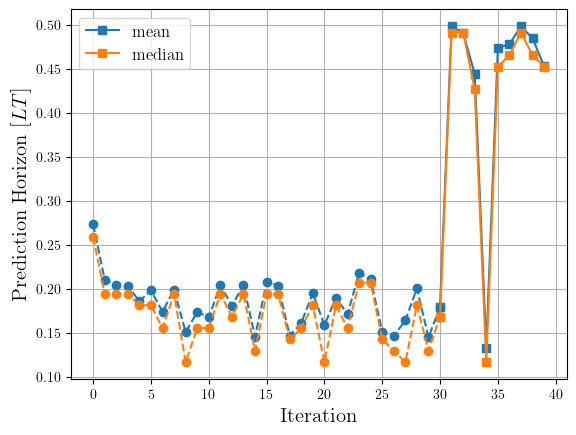

In [55]:
ph_mean = np.array(ph_mean)
ph_median = np.array(ph_median)

plt.plot(np.arange(0, n_pregp+1), ph_mean[0:n_pregp+1], color='C0', linestyle='--', marker='o', label='__nolegend__')
plt.plot(np.arange(n_pregp, ph_mean.shape[0]), ph_mean[n_pregp:], color='C0', linestyle='-', marker='s', label='mean')

plt.plot(np.arange(0, n_pregp+1), ph_median[0:n_pregp+1], color='C1', linestyle='--', marker='o', label='__nolegend__')
plt.plot(np.arange(n_pregp, ph_median.shape[0]), ph_median[n_pregp:], color='C1', linestyle='-', marker='s', label='median')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Prediction Horizon $[ LT ]$', fontsize=15)
plt.grid(True)

plt.legend(fontsize=12)

# plt.show()
plt.savefig(dir_name_rnn+'/plots/CORRECTED_PH.pdf', dpi=300, bbox_inches='tight')

In [56]:
np.savez(
    dir_name_rnn+'/corrected_ph',
    ph_median=ph_median,
    ph_mean=ph_mean,
    num_runs=num_runs,
    error_threshold=error_threshold,
)

write_dict = {
    'ph_median':ph_median,
    'ph_mean':ph_mean,
    'num_runs':num_runs,
    'error_threshold':error_threshold,
}
with open(dir_name_rnn+'/corrected_ph.txt', 'w') as f:
    f.write(str(write_dict))

In [ ]:
training_data_rnn_input.dtype

In [ ]:
def optim_func(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev=time_stddev,
        og_vars=og_vars,
        RNN_GRU=RNN_GRU,
        AR_RNN_GRU=AR_RNN_GRU,
        AR_AERNN_GRU=AR_AERNN_GRU,
        ae_net=ae_net,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=rnn_data_boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name='L2',
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        zoneout=zoneout_x0,
    ):
    
    compute_time = time.time()
    
    x = [elem for elem in np.array(x).flatten()]
    if len(x) < 3:
        x.append(zoneout)

    median_PH = trainGRU_and_return_PH(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev,
        og_vars,
        RNN_GRU,
        AR_RNN_GRU,
        AR_AERNN_GRU,
        ae_net,
        mytimecallback,
        SaveLosses,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name=reg_name,
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        error_threshold=0.5,
        xlabel_kwargs={'fontsize':15},
        ylabel_kwargs={'fontsize':15},
        legend_kwargs={'fontsize':12},
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [ ]:
x_bounds = [
    fRMS_bounds, # fRMS
    lambda_reg_bounds, # lambda_reg
]
if vary_zoneout == True:
    x_bounds.append(zoneout_bounds)

In [ ]:
dimensions = [
    eval(elem[3])(*elem[0:3]) for elem in x_bounds
]

In [ ]:
x0_gp = np.array(x0)[0:n_pregp]
print(x0_gp)

In [ ]:
y0_gp = -ph_median[0:n_pregp]
print(y0_gp)

In [ ]:
acq_func = "EI"
n_initial_points = 0
# n_calls = n_initial_points + len(x0_gp) + 10
n_calls = 10
print('n_calls : {}'.format(n_calls))

In [ ]:
optim_dict = {
    'fRMS_bounds':x_bounds[0],
    'lambda_reg_bounds':x_bounds[1],
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'num_x0':len(x0_gp),
    'random_state':prng_seed,
    'vary_zoneout':vary_zoneout,
}
if vary_zoneout == True:
    optim_dict['zoneout_bounds'] = x_bounds[2]
with open(dir_name_rnn + '/optim_params-corrected.txt', 'w') as f:
    f.write(str(optim_dict))

In [ ]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=[[elem2 for elem2 in elem1] for elem1 in x0_gp],
    y0=[elem1 for elem1 in y0_gp],
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)

In [ ]:
# %pdb

In [ ]:
testrnn_dirlist_new = []
testrnn_dirlist_idx_new = []
for dname in os.listdir(dir_name_rnn+'/tested_rnn'):
    if os.path.isdir(os.path.join(dir_name_rnn+'/tested_rnn', dname)):
        testrnn_dirlist_new.append(os.path.join(dir_name_rnn+'/tested_rnn', dname))
        rnnidx = int(testrnn_dirlist_new[-1][-3:])
        testrnn_dirlist_idx_new.append(rnnidx)

sorted_idx = np.argsort(testrnn_dirlist_idx_new)
testrnn_dirlist_idx_new = np.array(testrnn_dirlist_idx_new)[sorted_idx]
testrnn_dirlist_new = np.array(testrnn_dirlist_new)[sorted_idx]

In [ ]:
print(testrnn_dirlist_new)

In [ ]:
x0_new = [[elem2 for elem2 in elem1] for elem1 in x0]
ph_mean_new = [elem1 for elem1 in ph_mean]
ph_median_new = [elem1 for elem1 in ph_median]
ae_data_normalization_arr = normalization_constant_arr_aedata
error_threshold = 0.5

for dname in testrnn_dirlist_new[testrnn_dirlist.shape[0]:]:
    analysis_time = time.time()

    with open(dname+'/training_specific_params.txt', 'r') as f:
        lines = f.readlines()
    rnntrainspec_dict = eval(''.join(lines))

    lambda_reg_i = rnntrainspec_dict["lambda_reg"]
    fRMS_i = rnntrainspec_dict["fRMS"]
    zoneout_rate_i = rnntrainspec_dict["zoneout_rate"]
    
    x0_i = [fRMS_i, lambda_reg_i]
    if vary_zoneout == True:
        x0_i.append(zoneout_rate_i)
    x0_new.append(x0_i)

    npsavedata_fname = '/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz'
    
    with np.load(dname+npsavedata_fname, allow_pickle=True) as f:
        prediction_horizon_arr = np.array(f['prediction_horizon_arr'])

    if len(prediction_horizon_arr.shape) == 2:
        prediction_horizon_arr = prediction_horizon_arr[0]
    num_runs = prediction_horizon_arr.shape[0]
    median_idx = int(np.round(0.5*num_runs-1))
    quartile_1_idx = int(np.round(0.25*num_runs-1))
    quartile_3_idx = int(np.round(0.75*num_runs-1))

    prediction_horizon_arr.sort()

    median = prediction_horizon_arr[median_idx]
    quartile_1 = prediction_horizon_arr[quartile_1_idx]
    quartile_3 = prediction_horizon_arr[quartile_3_idx]
    IQR = quartile_3 - quartile_1

    prediction_horizon = np.mean(prediction_horizon_arr)
    stddev_ph = np.std(prediction_horizon_arr)

    analysis_time = time.time() - analysis_time
    s = 'error_threshold = {}, num_runs : {}\n'.format(error_threshold, num_runs)
    s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
    s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
    s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
    s += '1st quartile : {}, 3rd quartile : {}\n\n'.format(quartile_1, quartile_3)

    print('    analysis_time : {:.0f} sec.\n'.format(analysis_time)+s)
    
    ph_mean_new.append(prediction_horizon)
    ph_median_new.append(median)

In [ ]:
ph_mean_new = np.array(ph_mean_new)
ph_median_new = np.array(ph_median_new)

plt.plot(np.arange(0, n_pregp+1), ph_mean_new[0:n_pregp+1], color='C0', linestyle='--', marker='o', label='__nolegend__')
plt.plot(np.arange(n_pregp, ph_mean_new.shape[0]), ph_mean_new[n_pregp:], color='C0', linestyle='-', marker='s', label='mean')

plt.plot(np.arange(0, n_pregp+1), ph_median_new[0:n_pregp+1], color='C1', linestyle='--', marker='o', label='__nolegend__')
plt.plot(np.arange(n_pregp, ph_median_new.shape[0]), ph_median_new[n_pregp:], color='C1', linestyle='-', marker='s', label='median')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Prediction Horizon $[ LT ]$', fontsize=15)
plt.grid(True)

plt.legend(fontsize=12)

plt.show()
# plt.savefig(dir_name_rnn+'/plots/CORRECTED_PH.pdf', dpi=300, bbox_inches='tight')

In [ ]:
to_plot = [
    [np.array(x0_new)[:, 0], 'fRMS', 'fRMS', 'plt.semilogy'],
    [np.array(x0_new)[:, 1], '$\Lambda_{reg}$', 'lambda_reg', 'plt.semilogy']
]

for i in range(len(to_plot)):
    eval(to_plot[i][3])(np.arange(0, n_pregp+1), to_plot[i][0][0:n_pregp+1], color='C0', linestyle='--', marker='o', label='__nolegend__')
    eval(to_plot[i][3])(np.arange(n_pregp, to_plot[i][0].shape[0]), to_plot[i][0][n_pregp:], color='C0', linestyle='-', marker='s', label='mean')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(to_plot[i][1], fontsize=15)
    plt.grid(True)

    plt.legend(fontsize=12)

    plt.show()
    # plt.savefig(dir_name_rnn+'/plots/CORRECTED_PH.pdf', dpi=300, bbox_inches='tight')

In [ ]:
res

In [ ]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [ ]:
optim_idx

In [ ]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.plot(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.plot(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.plot([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [ ]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

In [ ]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
]
if vary_zoneout == True:
    xoptim_names.append(
        [r'$p^{zoneout}$', 'zoneout', plt.plot]
    )

for i in range(len(xoptim_names)):
    a = n_initial_points + len(x0)
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
dir_list = os.listdir(dir_name_rnn+'/tested_rnn')
# dir_list

In [ ]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_rnn/'+dir_name+'/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [ ]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [ ]:
idx, dir_list[idx[0]]

In [ ]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

In [ ]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.plot(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.plot(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation